In [80]:
import pandas as pd
import numpy as np
import glob
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [81]:
## Load the data
filenames = glob.glob("ETFs" + "/*.csv")
print(filenames)

['ETFs/jjm.us.csv', 'ETFs/schg.us.csv', 'ETFs/xrt.us.csv', 'ETFs/ivv.us.csv', 'ETFs/dsum.us.csv', 'ETFs/dbem.us.csv', 'ETFs/fgb.us.csv', 'ETFs/tlt.us.csv', 'ETFs/mchi.us.csv', 'ETFs/bsji.us.csv', 'ETFs/gaa.us.csv', 'ETFs/iwx.us.csv', 'ETFs/frn.us.csv', 'ETFs/grn.us.csv', 'ETFs/amjl.us.csv', 'ETFs/cly.us.csv', 'ETFs/hgi.us.csv', 'ETFs/eny.us.csv', 'ETFs/rdvy.us.csv', 'ETFs/fam.us.csv', 'ETFs/grwn.us.csv', 'ETFs/ige.us.csv', 'ETFs/chix.us.csv', 'ETFs/qyld.us.csv', 'ETFs/qjpn.us.csv', 'ETFs/iqde.us.csv', 'ETFs/tmv.us.csv', 'ETFs/egpt.us.csv', 'ETFs/xph.us.csv', 'ETFs/fcor.us.csv', 'ETFs/ryh.us.csv', 'ETFs/jja.us.csv', 'ETFs/dxjs.us.csv', 'ETFs/pfm.us.csv', 'ETFs/qlta.us.csv', 'ETFs/vioo.us.csv', 'ETFs/rzv.us.csv', 'ETFs/fta.us.csv', 'ETFs/eema.us.csv', 'ETFs/xbi.us.csv', 'ETFs/qqq.us.csv', 'ETFs/kold.us.csv', 'ETFs/hyzd.us.csv', 'ETFs/xpp.us.csv', 'ETFs/nfo.us.csv', 'ETFs/iwl.us.csv', 'ETFs/iemg.us.csv', 'ETFs/fbnd.us.csv', 'ETFs/fndf.us.csv', 'ETFs/gvi.us.csv', 'ETFs/ashr.us.csv', 'ETFs/

In [82]:
# df = pd.read_csv("aia.us.csv")
df = pd.DataFrame()
count = 0
for file in filenames:
    if (count > 100):
        break
    # cur_df = pd.read_csv(file)
    # df = pd.concat([df, cur_df], ignore_index=True)
    # count += 1
    try:
        cur_df = pd.read_csv(file)
        df = pd.concat([df, cur_df], ignore_index=True)
        count += 1
    except Exception as e:
        print(f"Error reading {file}: {e}")
        
print(df)

df.to_csv("raw_data2.csv", index=False)


              Date    Open    High      Low   Close  Volume  OpenInt
0       2007-10-30   49.70   49.70   49.700   49.70     100        0
1       2007-10-31   49.68   50.00   49.680   50.00    4700        0
2       2007-11-01   49.36   49.36   49.100   49.13   19100        0
3       2007-11-02   49.25   49.25   49.050   49.05    4300        0
4       2007-11-05   48.94   48.94   48.940   48.94     100        0
...            ...     ...     ...      ...     ...     ...      ...
187660  2017-11-06  148.86  150.06  148.840  148.90   10534        0
187661  2017-11-07  149.33  149.72  147.920  148.56   26603        0
187662  2017-11-08  148.08  148.08  146.840  147.53   14858        0
187663  2017-11-09  146.92  147.36  146.388  147.36   19290        0
187664  2017-11-10  147.03  147.09  146.380  146.80   13854        0

[187665 rows x 7 columns]


In [73]:
## preprocessing

# Add new features
# 1. calculate Simple Return (Close - Open) feature
df['Simple_Return'] = (df['Close'] - df['Open'])/df['Open']
# 2. Calculate the Simple Moving Average (SMA) over a five row window for Open, High, Low, and Close
window_size = 5
df["SMA_Open"] = df["Open"].rolling(window=window_size).mean()
df["SMA_High"] = df["High"].rolling(window=window_size).mean()
df["SMA_Low"] = df["Low"].rolling(window=window_size).mean()
df["SMA_Close"] = df["Close"].rolling(window=window_size).mean()
# 3. feature extration from the Date column, get Year, Month, Day of Month, and Day of Week features
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day_of_Month'] = df['Date'].dt.day
df['Day_of_Week'] = df['Date'].dt.weekday
# 4. convert the year column to elapsed time from the first year (or use it to group data?)
df["Year"] = df["Year"] - 2007
# 5. convert the Month column into categorical feature based on the best and worst months analysis using one hot encoding 
df["Best_Months"] = df["Month"].isin([2, 3, 10, 11]).astype(int)
df["Intermediate_Months"] = df["Month"].isin([0, 6, 9]).astype(int)
df["Worst_Months"] = df["Month"].isin([1, 4, 5, 7, 8]).astype(int)
# 6. convert the day of month column into categorical feature based on the start point (1 - 9), midpoint (10 - 20), and end point (20+)
# using one hot encoding
df["Month_Startpoint"] = np.where(df["Month"] < 9, 1, 0)
df["Month_Midpoint"] = np.where((df["Month"] >= 9) & (df["Month"] < 20), 1, 0)
df["Month_Endpoint"] = np.where(df["Month"] >= 20, 1, 0)
# 7. calculate cosine and sine values of Day_of_Week to preserve the relation between days
df['Day_of_Week_sin'] = np.sin(df['Day_of_Week'] * (2 * np.pi / 7))
df['Day_of_Week_cos'] = np.cos(df['Day_of_Week'] * (2 * np.pi / 7))

# Calculate labels (continuous and discrete)
# Continuous: Log Return feature Using Close price (Log Return = ln(Close_t / Close_t-1) * 100)
df['Log_Return_Percentage'] = np.log(df['Close'] / df['Close'].shift(1)) * 100
# Discrete: calculate from the sign of the Log Return feature
df['label'] = (df['Log_Return_Percentage'] > 0).astype(int)

# detect missing data, and replace all empty spaces or null values with NaN
df = df.fillna(value=np.nan)
# remove all rows with missing data
df = df.iloc[4:]
# check if there is remaining missing data
print(df.isnull().sum())

# print dataset
df

Date                     0
Open                     0
High                     0
Low                      0
Close                    0
Volume                   0
OpenInt                  0
Simple_Return            0
SMA_Open                 0
SMA_High                 0
SMA_Low                  0
SMA_Close                0
Year                     0
Month                    0
Day_of_Month             0
Day_of_Week              0
Best_Months              0
Intermediate_Months      0
Worst_Months             0
Month_Startpoint         0
Month_Midpoint           0
Month_Endpoint           0
Day_of_Week_sin          0
Day_of_Week_cos          0
Log_Return_Percentage    0
label                    0
dtype: int64


,Date,Open,High,Low,Close,Volume,OpenInt,Simple_Return,SMA_Open,SMA_High,...,Best_Months,Intermediate_Months,Worst_Months,Month_Startpoint,Month_Midpoint,Month_Endpoint,Day_of_Week_sin,Day_of_Week_cos,Log_Return_Percentage,label
4,2007-11-05,48.94,48.94,48.940,48.94,100,0,0.000000,49.386,49.450,...,1,0,0,0,1,0,0.000000,1.000000,-0.224513,0
5,2007-11-06,49.69,49.73,49.660,49.66,6600,0,-0.000604,49.384,49.456,...,1,0,0,0,1,0,0.781831,0.623490,1.460472,1
6,2007-11-07,48.94,48.94,48.940,48.94,1000,0,0.000000,49.236,49.244,...,1,0,0,0,1,0,0.974928,-0.222521,-1.460472,0
7,2007-11-08,48.72,48.72,48.720,48.72,100,0,0.000000,49.108,49.116,...,1,0,0,0,1,0,0.433884,-0.900969,-0.450543,0
8,2007-11-09,48.55,48.55,48.550,48.55,200,0,0.000000,48.968,48.976,...,1,0,0,0,1,0,-0.433884,-0.900969,-0.349543,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187660,2017-11-06,148.86,150.06,148.840,148.90,10534,0,0.000269,148.652,149.673,...,1,0,0,0,1,0,0.000000,1.000000,-0.335233,0
187661,2017-11-07,149.33,149.72,147.920,148.56,26603,0,-0.005156,148.814,149.685,...,1,0,0,0,1,0,0.781831,0.623490,-0.228602,0
187662,2017-11-08,148.08,148.08,146.840,147.53,14858,0,-0.003714,148.532,149.385,...,1,0,0,0,1,0,0.974928,-0.222521,-0.695737,0
187663,2017-11-09,146.92,147.36,146.388,147.36,19290,0,0.002995,148.320,149.034,...,1,0,0,0,1,0,0.433884,-0.900969,-0.115297,0


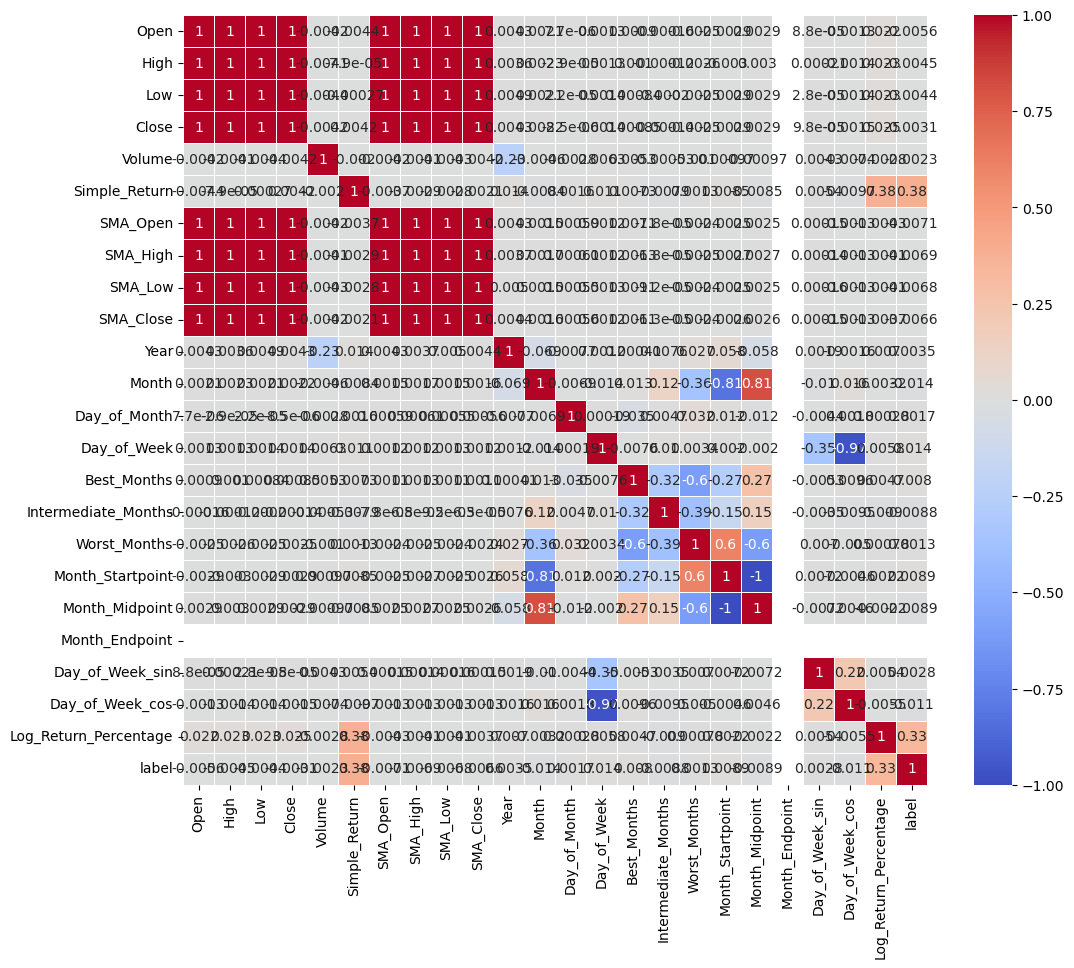

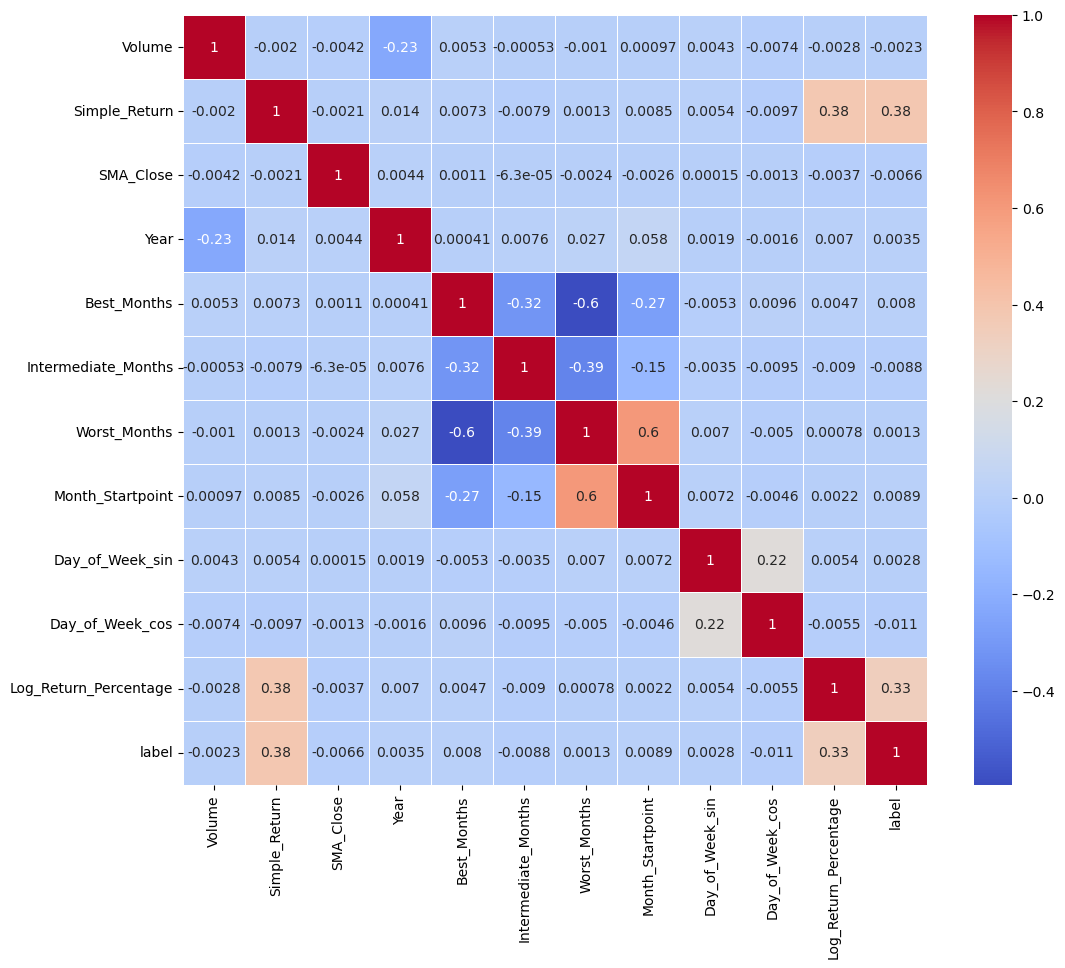

In [74]:
# feature selection
# remove irrelvant features
df = df.drop(["Date", "OpenInt"], axis=1)
# use Pearson correlation to detect features highly correlated with each other
corr_maxtrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_maxtrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.show()
# remove features that are highly correlated with each other with a threshold of 0.6 and features that have weak correlation with labels
df = df.drop(["Open", "High", "Low", "Close", "SMA_Open", "SMA_High", "SMA_Low", "Month", "Day_of_Month", "Day_of_Week", "Month_Midpoint", "Month_Endpoint"], axis=1)
# show the heatmap after highly correlated features are removed
corr_maxtrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_maxtrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.show()

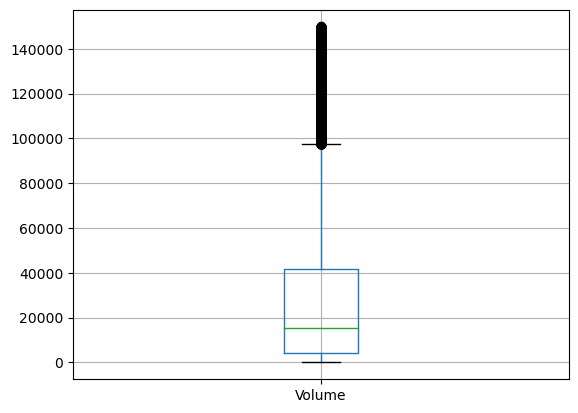

In [75]:
# detect outliers and analyze
# remove datapoints that has Volumn >= 150000
df = df[df["Volume"] < 150000]
df = df[df["SMA_Close"] < 5000]
# plot box plots
# box_plots = df.boxplot(column="SMA_Close")
# box_plots = df.boxplot(column=["Year", "Best_Months", "Intermediate_Months", "Worst_Months", "Month_Startpoint", "Day_of_Week_sin", "Day_of_Week_cos"])
box_plots = df.boxplot(column="Volume")

In [76]:
# split and normalize data; Note: need to run separately from the cell of data with discrete label
# data with continuous label
# Split Dataset randomly, 75% for training, and 25% for testing
dataset = df.drop("label", axis = 1)
y = df["Log_Return_Percentage"]
x_train, x_test, y_train, y_test = train_test_split(dataset, y, test_size=0.25, random_state=334)
# normalize the data using standard scalar
scalar = StandardScaler()
x_train = scalar.fit_transform(x_train)
x_test = scalar.transform(x_test)
# get the label from normalized data
y_train = x_train[:, x_train.shape[1] - 1]
y_test = x_test[:, x_test.shape[1] - 1]
# convert features datasets into pandas dataframe
x_train_pd = pd.DataFrame(x_train, columns=dataset.columns).drop("Log_Return_Percentage", axis=1)
x_test_pd = pd.DataFrame(x_test, columns=dataset.columns).drop("Log_Return_Percentage", axis=1)
# Save the train and test sets to files
x_train_pd.to_csv('continuous/standard/xTrain_continuous.csv', index=False)
x_test_pd.to_csv('continuous/standard/xTest_continuous.csv', index=False)
pd.DataFrame(y_train, columns=["label"]).to_csv('continuous/standard/yTrain_continuous.csv', index=False)
pd.DataFrame(y_test, columns=["label"]).to_csv('continuous/standard/yTest_continuous.csv', index=False)


In [71]:
# data with discrete label
# Split Dataset randomly, 70% for training, and 30% for testing
y = df["label"]
X = df.drop(["Log_Return_Percentage", "label"], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=334)
# normalize the data using standard scalar
scalar = StandardScaler()
x_train = scalar.fit_transform(x_train)
x_test = scalar.transform(x_test)
# Save the train and test sets to files
pd.DataFrame(x_train, columns=X.columns).to_csv('discrete/standard/xTrain_discrete.csv', index=False)
pd.DataFrame(x_test, columns=X.columns).to_csv('discrete/standard/xTest_discrete.csv', index=False)
y_train.to_csv('discrete/standard/yTrain_discrete.csv', index=False)
y_test.to_csv('discrete/standard/yTest_discrete.csv', index=False)